# Best result: **0.98512**

### Installing Dependencies

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Nov 18 13:57:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In our test, there will be 990 images for which you will need to predict the class.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm.auto import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Below, we use a wrapper around the dataset for convenient processing. You should understand what happens with `LabelEncoder` and `torch.Transformation`.

`ToTensor` converts a PIL Image with pixel values in the range [0, 255] into a `FloatTensor` of size (C x H x W) in the range [0, 1]. Then, normalization is applied as follows:

$
input = \frac{input - \mu}{\text{standard deviation}}
$

where the constants $\mu$ (mean) and $\text{standard deviation}$ are channel-wise values based on ImageNet.

It is also worth noting that we override the `__getitem__` method for ease of working with this data structure. Additionally, `LabelEncoder` is used to convert string class labels to IDs and back. According to the dataset description, the images are of different sizes because they were directly extracted from videos. Therefore, we need to standardize their dimensions, which is handled by the `_prepare_sample` method.

In [ ]:
class SimpsonsDataset(Dataset):
    """
    A dataset with images that simultaneously loads them from folders, performs scaling, 
    and converts them into PyTorch tensors.
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#directories with train and test data
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Let's look on soome examples in data

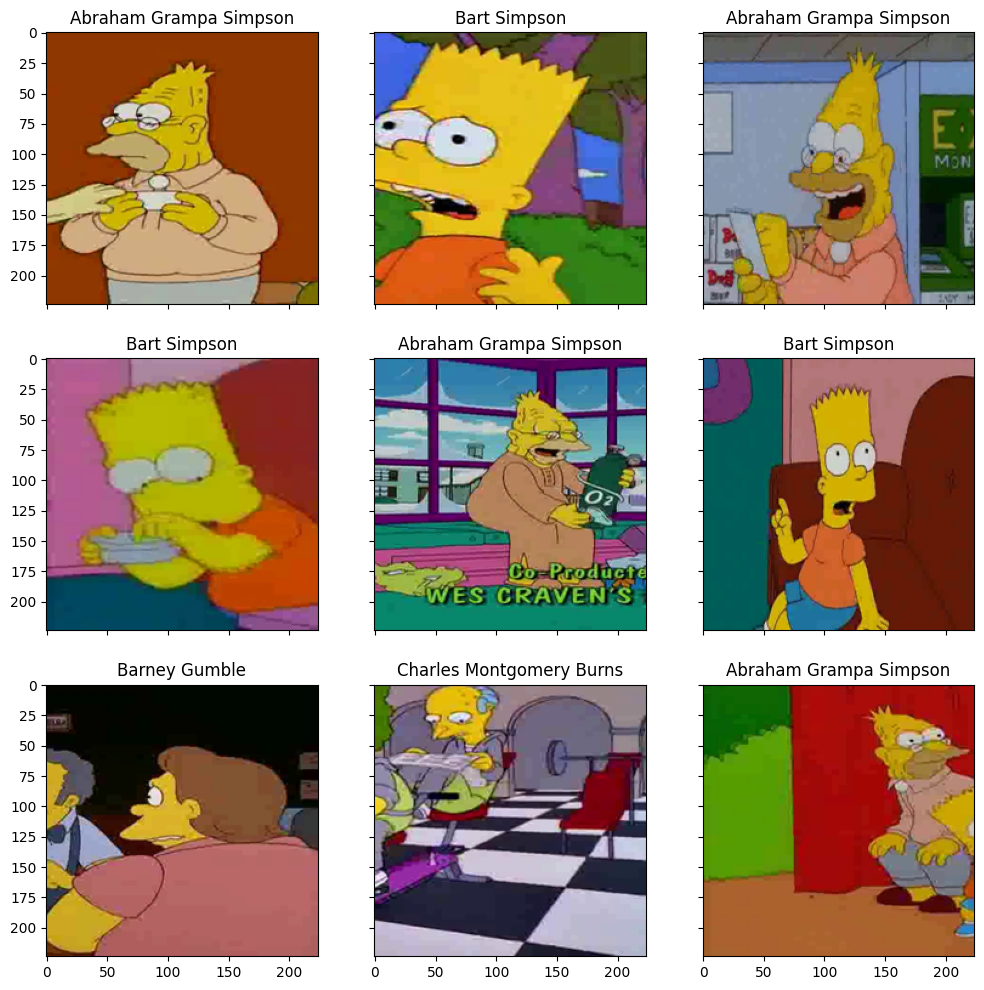

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Building a Neural Network

Your mini-assignment for the first week is to run this network, making it easier to participate in the competition.

This architecture is very simple and is intended to establish a basic understanding and provide a straightforward submission to Kaggle.


*Description of layers*:

1. Input dimensions: 3x224x224  
2. Dimensions after the layer: 8x111x111  
3. 16x54x54  
4. 32x26x26  
5. 64x12x12  
6. Output: 96x5x5  

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, learning_rate=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if learning_rate is not None:
            opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        else:
            opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{} classes with model:".format(n_classes))
print(simple_cnn)

we will classify :42 classes with model:
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_fe

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 2.7336229035046244


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 2.7336     val_loss 2.1155 train_acc 0.2299 val_acc 0.4305


  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.655696430846577


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.6557     val_loss 1.4033 train_acc 0.5511 val_acc 0.6190


  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.028536990339023


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 1.0285     val_loss 1.0510 train_acc 0.7116 val_acc 0.7186


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.7195551024097433


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.7196     val_loss 0.9720 train_acc 0.7967 val_acc 0.7423


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.5315131892694153


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.5315     val_loss 0.9087 train_acc 0.8471 val_acc 0.7702


Let's build learning curves.

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

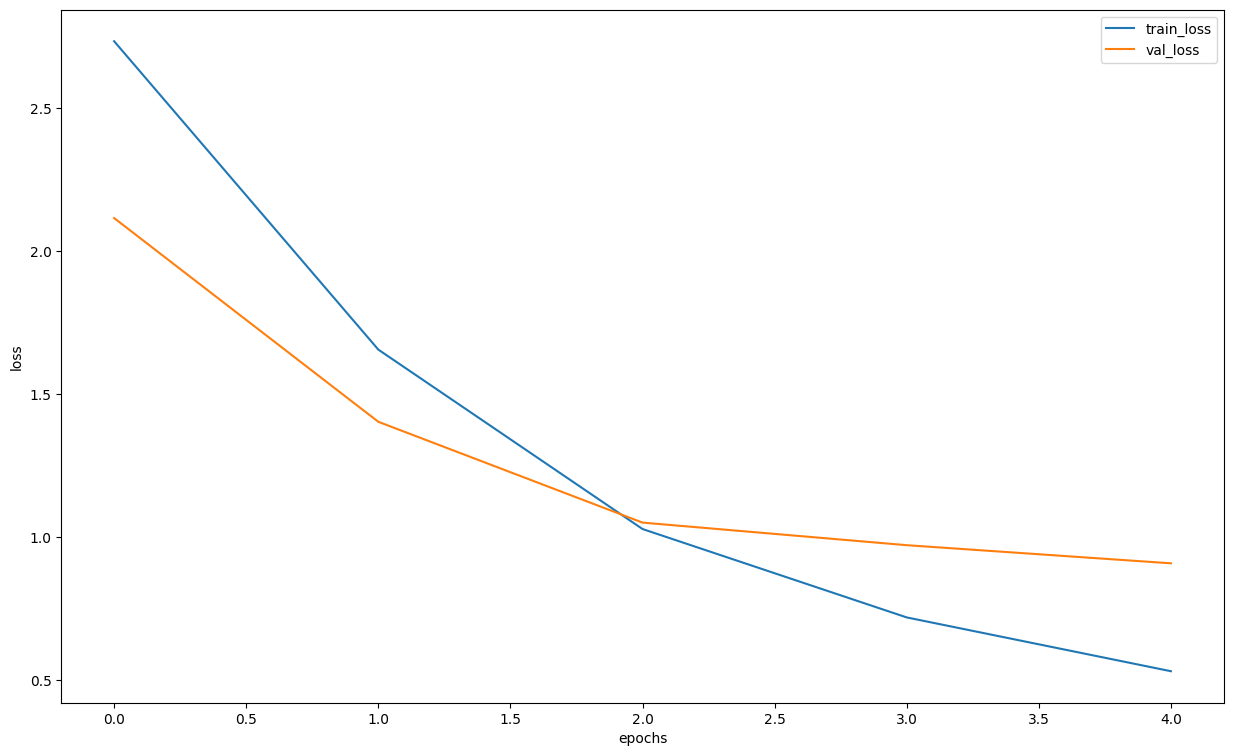

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Let’s understand how to make a submission.  

We have a network and its `eval` method, which switches the model to prediction mode. It's important to note that the last layer of our model uses a softmax function, which outputs a vector of probabilities indicating the likelihood of the object belonging to each class. Let’s leverage this functionality for our predictions.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Used metric - F1 score

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


NameError: ignored

Let's create a cool visualisation to see how confident the network is in its predictions. You can use this to debug and verify the accuracy of the outputs.

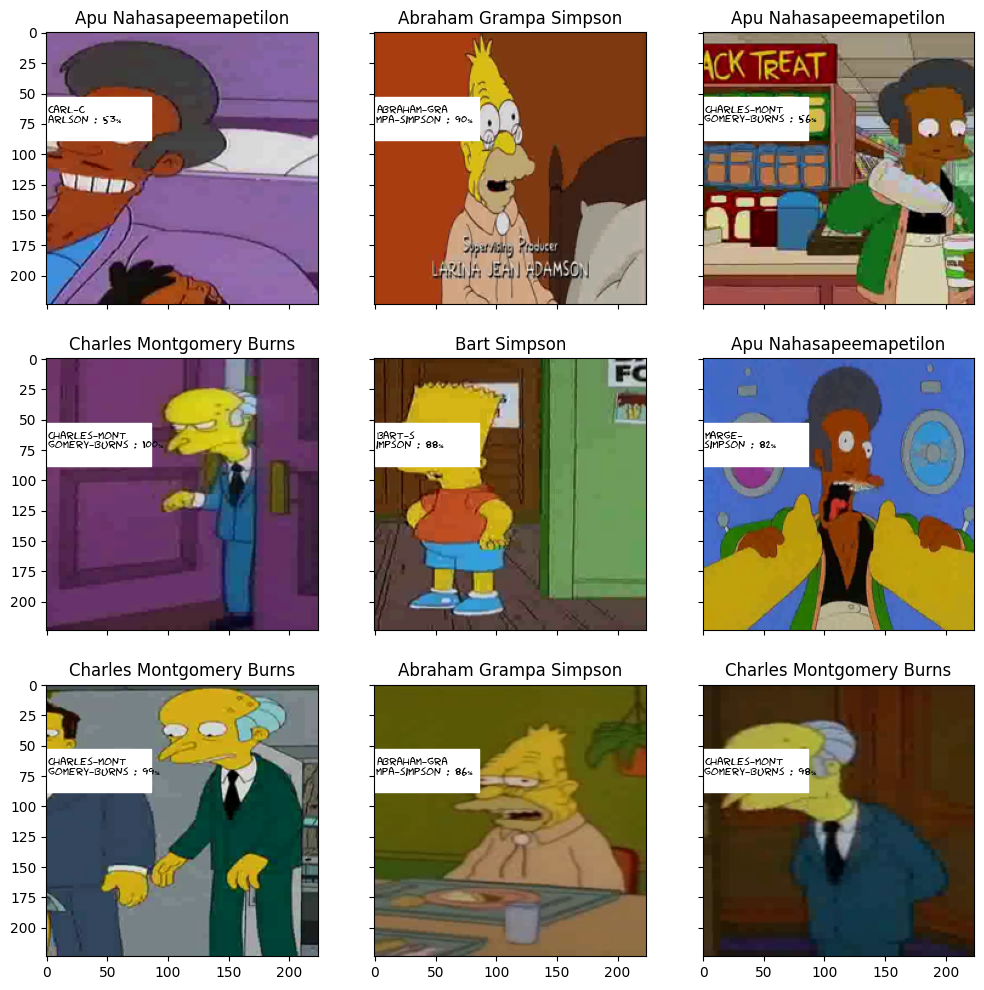

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## As seen above, I conducted training not for two epochs but for five. Why not more? In most cases, additional epochs led to overfitting, where the loss on the training set continued to decrease, but the loss on the validation set started to increase. Perhaps I was incredibly fortunate, but even this standard neural network achieved a score of 9 out of 15 on Kaggle. In summary, further improvement is beyond the scope of this attempt.

## On a serious note, the fact that such a small neural network starts overfitting after 5 epochs indicates that there isn't enough training data, and it might be worth exploring transfer learning. However, for now, we will stick with the standard approach. Below is a network that incorporates batch normalization.

In [ ]:
class BatchNormCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
batch_norm_cnn = BatchNormCnn(n_classes).to(DEVICE)
print("we will classify :{} classes with model:".format(n_classes))
print(batch_norm_cnn)

we will classify :42 classes with model:
BatchNormCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_

In [ ]:
history = train(train_dataset, val_dataset, model=batch_norm_cnn, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.6236903608600852


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.6237     val_loss 1.2173 train_acc 0.5708 val_acc 0.6655


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.8500996826484603


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.8501     val_loss 0.9511 train_acc 0.7631 val_acc 0.7522


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.5314753470800357


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.5315     val_loss 0.9302 train_acc 0.8483 val_acc 0.7658


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.33866222204581303


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.3387     val_loss 0.8143 train_acc 0.8967 val_acc 0.8162


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.23307563654954544


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.2331     val_loss 0.8728 train_acc 0.9285 val_acc 0.8034


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

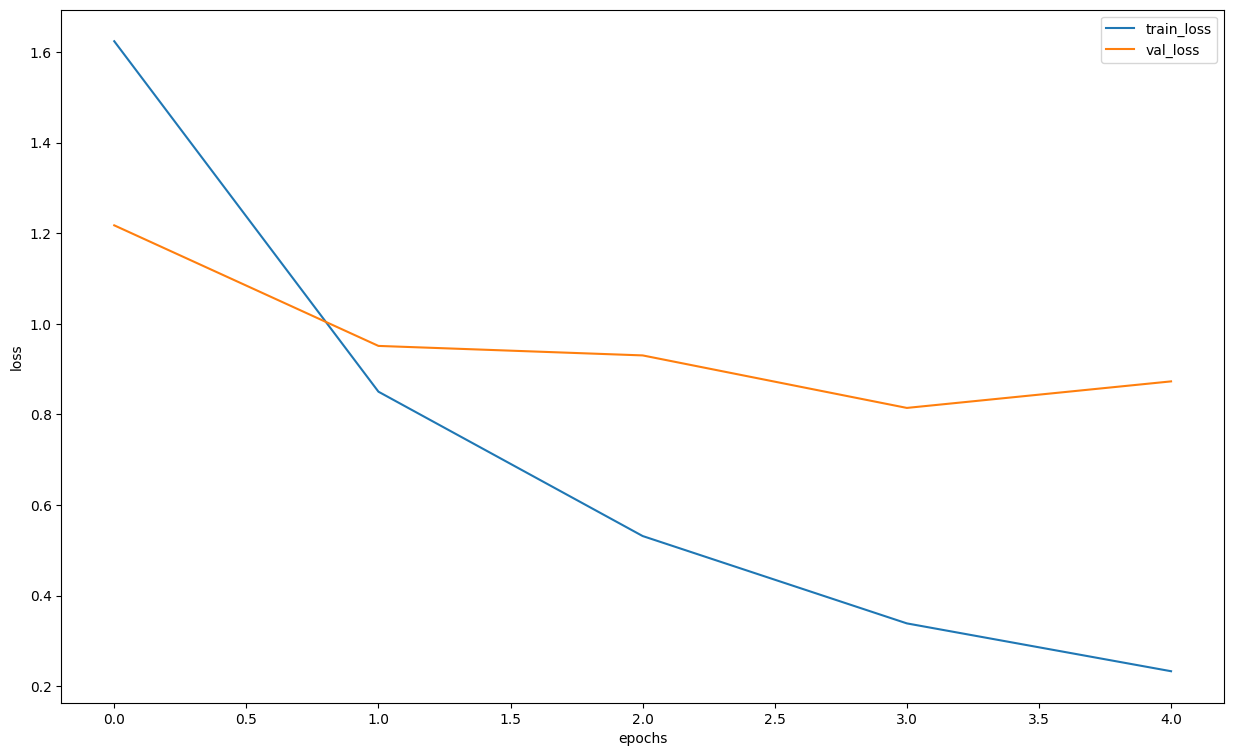

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(batch_norm_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('batch_norm_cnn_baseline.csv', index=False)

### And... we gained one more point. Not bad, but not great either. It might even be random due to the initial weights—I didn’t bother restarting to confirm. Ideally, it would have been worth experimenting with dropout and skip connections, but... implementing skip connections turned out to be more complex than the lectures suggested. Properly aligning dimensions requires extra effort, and adding layers that don't meaningfully contribute just to implement skip connections felt unnecessary. 

As for dropout, it theoretically could have mitigated overfitting by reducing the number of parameters, but I chose not to pursue it. In any case, the main focus here is transfer learning, so let’s move on to that.

In [ ]:
from torchvision import models

In [ ]:
resnet_152_model = models.resnet152(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 101MB/s] 


In [ ]:
print(resnet_152_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## The model description is extensive, but the key detail is at the end: the final layer is called `fc` (final classifier?). We freeze the entire network and then replace the last layer with a fully connected layer tailored to our specific requirements.

In [ ]:
for parameter in resnet_152_model.parameters():
  parameter.requires_grad = False
resnet_152_model.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)
resnet_152_model = resnet_152_model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=resnet_152_model, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.839425999257616


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.8394     val_loss 1.3034 train_acc 0.5511 val_acc 0.6779


  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.0538148765951534


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.0538     val_loss 1.0221 train_acc 0.7311 val_acc 0.7356


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.8622365611887668


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.8622     val_loss 0.9052 train_acc 0.7734 val_acc 0.7585


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.7523199647723873


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.7523     val_loss 0.8931 train_acc 0.7972 val_acc 0.7554


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.6926059758247817


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.6926     val_loss 0.8422 train_acc 0.8121 val_acc 0.7637


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

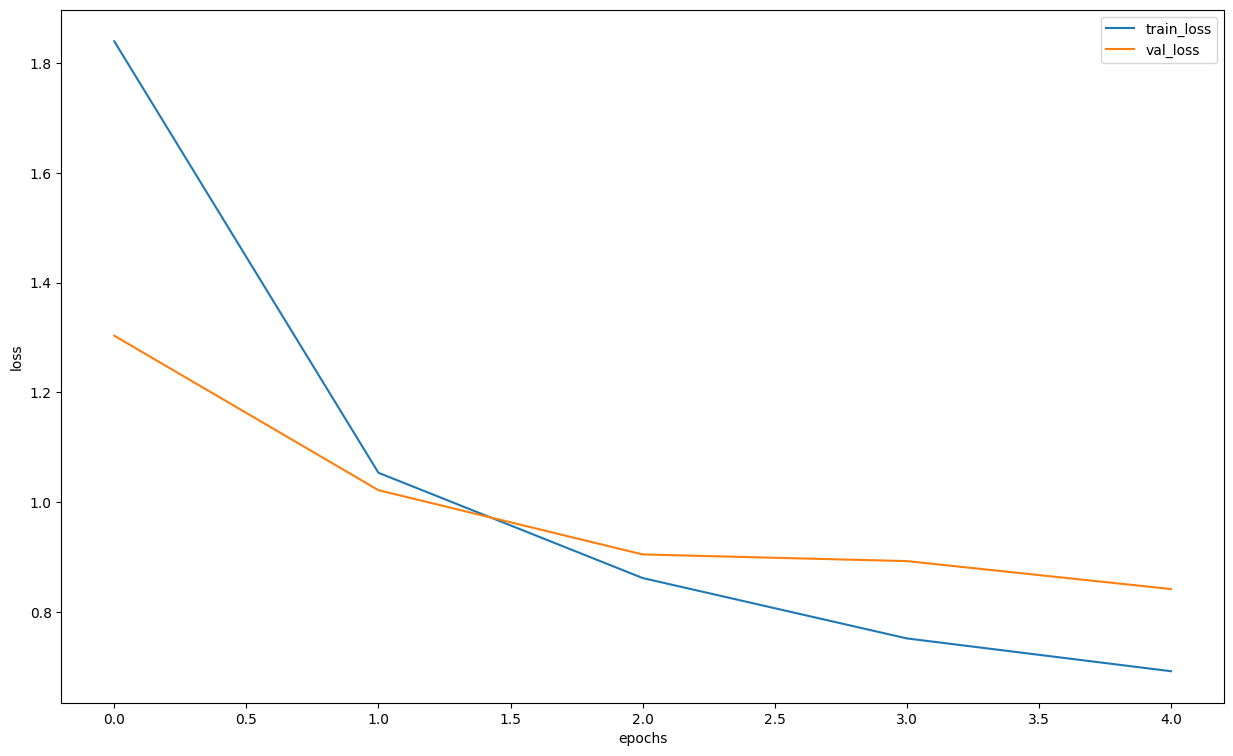

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
import pandas as pd
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet_152_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('resnet_152_results.csv', index=False)

## The results are disappointing—the simple neural network performed better. The takeaway here is that unfreezing only one layer is insufficient. So, let’s try unfreezing more layers, but this time on EfficientNet V2 S. Why this model? From the seminars, I gathered that it is highly efficient in terms of the number of parameters and performance. Additionally, I prefer avoiding excessively long computation times.

In [ ]:
efficient_model = models.efficientnet_v2_s(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(len(efficient_model.features))

8


In [ ]:
print(efficient_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## As I understand it, features represent something akin to "super-layers." We freeze the first 5 out of the available 8, replace the classifier with minimal modifications, and proceed confidently.

In [ ]:
for i in range(5):
  feature = efficient_model.features[i]
  for parameter in feature.parameters():
    parameter.requires_grad = False
efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=n_classes, bias=True)
)
efficient_model = efficient_model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=efficient_model, epochs=5, batch_size=64, learning_rate=1e-4)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.0907638934480361


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.0908     val_loss 0.2142 train_acc 0.7676 val_acc 0.9496


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.19274876947706387


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.1927     val_loss 0.1532 train_acc 0.9522 val_acc 0.9643


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.06870750238816027


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.0687     val_loss 0.1250 train_acc 0.9830 val_acc 0.9715


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.03447792444673896


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.0345     val_loss 0.1549 train_acc 0.9910 val_acc 0.9645


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.0381426458833999


  0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.0381     val_loss 0.1253 train_acc 0.9897 val_acc 0.9727


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

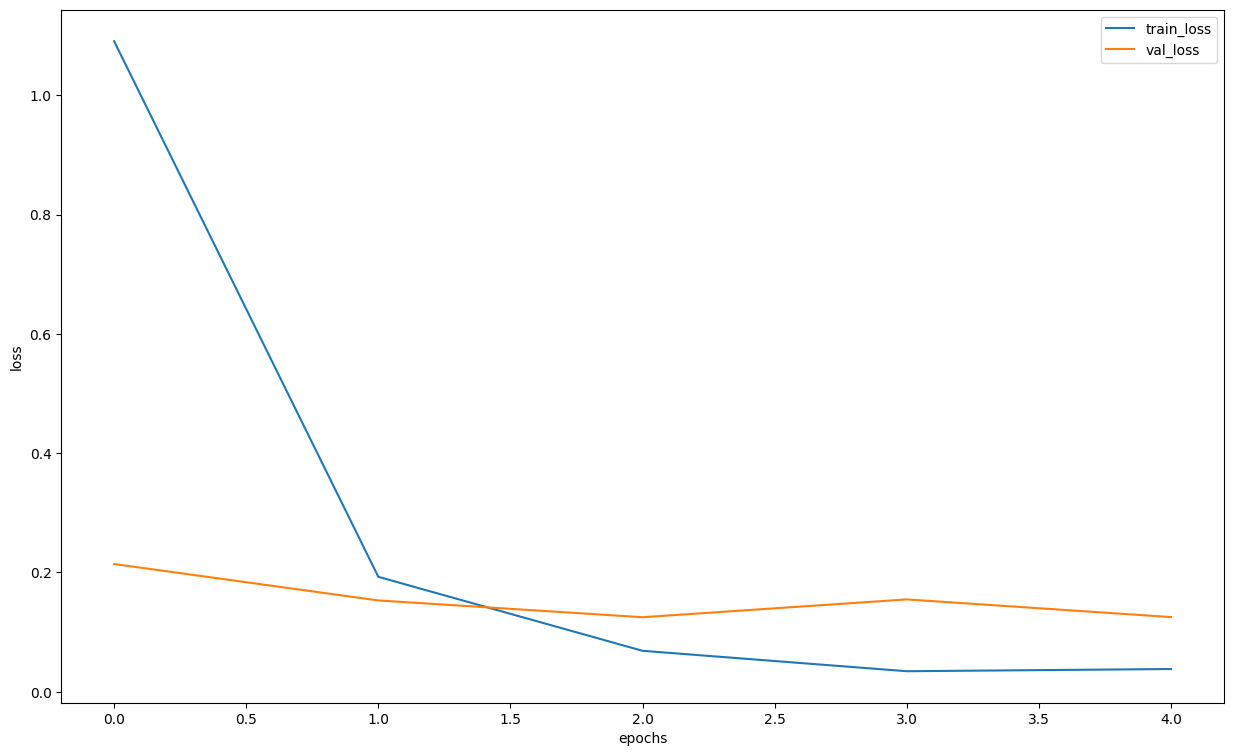

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
import pandas as pd
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(efficient_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('efficient_v2_s_results.csv', index=False)

# It is worth noting that the standard learning rate of `1e-3` did not work here—by the second epoch, the loss started increasing uncontrollably. While it eventually began to decrease again, the damage was already done. Lowering the learning rate solved the issue, and everything worked perfectly. 

I believe it would have been possible to train for longer and implement an exponentially decaying learning rate, but since the score reached 0.985, I decided not to push further. 

I removed numerous failed attempts from the process, so if it seems like I wasn’t putting much effort into this, that’s not the case—this result is the culmination of many unsuccessful trials. If you have recommendations on where to find comprehensive resources about skip connections (not just "add two lines in the forward pass and it works," but proper dimensional alignment of intermediate feature maps), I would greatly appreciate it.